# Predicción de ETo utilizando Regresión Lineal

In [49]:
import numpy as np
import pandas as pd
from eto_pm import calc_eto

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import matplotlib.pyplot as plt

### Estimar ETo aplicando Penman-Monteith

In [50]:
df = pd.read_csv('custom_weather_data.csv', index_col=['Date'], parse_dates=True)
print(df.index.dtype) # Asegurar que el índice es datetime
df

datetime64[ns]


,Solar Radiation (W/m²),Heat Flux Density (W/m²),Mean Temperature (°C),Vapor Pressure Slope (kPa/ºC),Wind Speed (m/s),T_min,T_max
Date,,,,,,,
2023-01-01,384.987706,228.234406,25.320376,0.952271,9.276121,21.204441,27.827692
2023-01-02,435.759804,278.652402,26.446891,1.004507,6.206753,19.667378,28.572243
2023-01-03,443.778788,260.028145,28.814782,1.049978,5.695680,27.047165,35.596402
2023-01-04,396.162356,247.336488,21.838875,0.851710,3.409369,20.112822,26.648638
2023-01-05,408.274535,243.737733,26.264700,0.987383,2.279993,20.979772,31.902069
...,...,...,...,...,...,...,...
2025-09-22,400.212834,241.387236,23.614501,0.901570,5.793780,21.672403,30.465031
2025-09-23,354.462393,206.505274,23.263684,0.891987,6.971197,19.406041,26.051675
2025-09-24,378.712282,232.502462,26.524220,0.995561,7.957566,19.547760,32.999992


In [51]:
df = calc_eto(df, 
              mt='Mean Temperature (°C)',
              sr='Solar Radiation (W/m²)',
              ws='Wind Speed (m/s)',
              vps='Vapor Pressure Slope (kPa/ºC)')

In [52]:
print('ETo mínima:', round(df['ETo (mm/día)'].min(),2))
print('ETo máxima:', round(df['ETo (mm/día)'].max(),2))
print('ETo media:', round(df['ETo (mm/día)'].mean(),2))

ETo mínima: 2.3
ETo máxima: 23.87
ETo media: 12.74


### Preprocesar series temporales

In [53]:
features = ['Solar Radiation (W/m²)', 'Heat Flux Density (W/m²)', 'Mean Temperature (°C)', 'Vapor Pressure Slope (kPa/ºC)', 'Wind Speed (m/s)', 'T_min', 'T_max']
target = 'ETo (mm/día)'
lookback = 3

def secuencias(df, features, target, lookback):
    X, y = [], []
    for i in range(len(df) - lookback):
        X.append(df[features].iloc[i:i+lookback].values) # Recoge los features dejando fueras los n señalados como lookback
        y.append(df[target].iloc[i+lookback]) # Para cada paso temporal guarda n lookback como target
    return np.array(X), np.array(y)

In [54]:
# Establecer la longitud de los datos para entrenamiento
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]

# Estandarizar datos
scaler = MinMaxScaler()
train.loc[:, features] = scaler.fit_transform(train[features])
test.loc[:, features] = scaler.transform(test[features])

# Crear los conjuntos separados X e y para entrenamiento y validación
X_train, y_train = secuencias(train, features, target, lookback)
X_test, y_test = secuencias(test, features, target, lookback)

# Redimensionar los arrays
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [55]:
print(f'Entrenamiento:\nForma de X: {X_train.shape}\tForma de y: {y_train.shape}')
print()
print(f'Validación:\nForma de X: {X_test.shape}\tForma de y: {y_test.shape}')

Entrenamiento:
Forma de X: (697, 21)	Forma de y: (697,)

Validación:
Forma de X: (297, 21)	Forma de y: (297,)


### Construir modelo

In [56]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

In [57]:
# Evaluación con MSE y MAE
mse_train, mae_train = root_mean_squared_error(y_train, y_pred_train), mean_absolute_error(y_train, y_pred_train)
mse_valid, mae_valid = root_mean_squared_error(y_test, y_pred_test), mean_absolute_error(y_test, y_pred_test)

print(f'Entrenamiento:\nMSE: {mse_train:.2f}\tMAE: {mae_train:.2f}')
print()
print(f'Validación:\nMSE: {mse_valid:.2f}\tMAE: {mae_valid:.2f}')

Entrenamiento:
MSE: 0.94	MAE: 0.74

Validación:
MSE: 0.90	MAE: 0.71


### Visualización

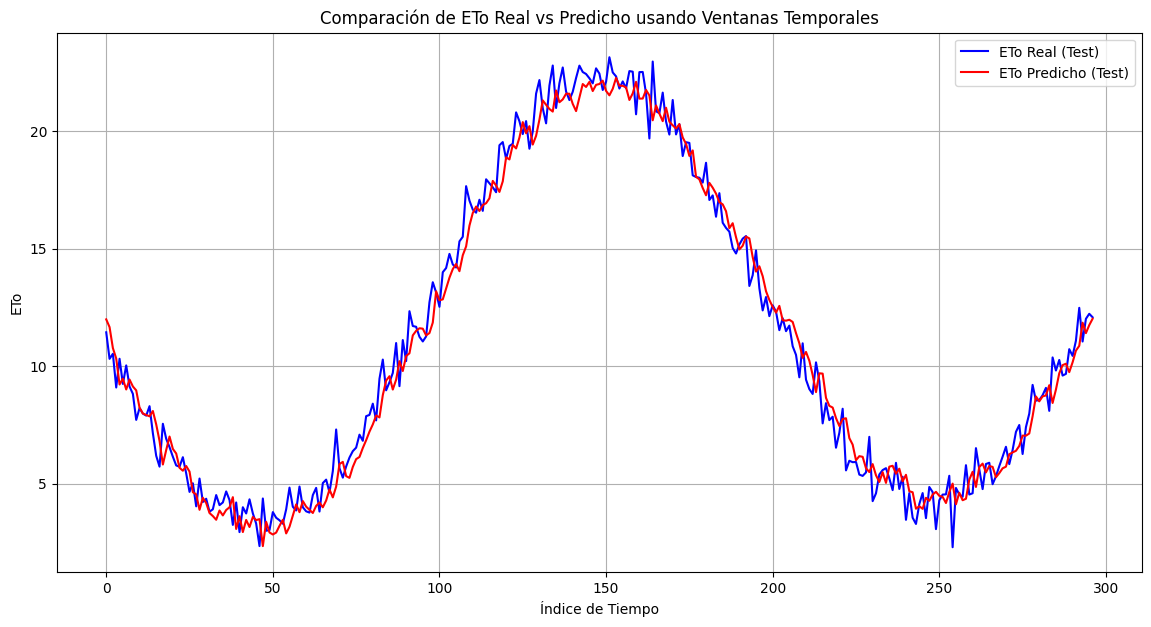

In [58]:
plt.figure(figsize=(14, 7))

plt.plot(y_test, label='ETo Real (Test)', color='blue', linestyle='-')

plt.plot(y_pred_test, label='ETo Predicho (Test)', color='red', linestyle='-')

plt.xlabel('Índice de Tiempo')
plt.ylabel('ETo')
plt.title('Comparación de ETo Real vs Predicho usando Ventanas Temporales')
plt.legend()
plt.grid()
plt.show()

### Predicciones futuras

In [71]:
# Coger los últimos 3 días y redimensionar
X_pred = df[features].iloc[-3:].values
print(f'Forma antes de redimensionar: {X_pred.shape}')
X_pred = X_pred.reshape(1, -1)
print(f'Forma después de redimensionar: {X_pred.shape}\n')

# Pasar al modelo
pred = modelo.predict(X_pred)
print(f'ETo estimada para el siguiente día: {pred[0]:.2f} mm')



Forma antes de redimensionar: (3, 7)
Forma después de redimensionar: (1, 21)

ETo estimada para el siguiente día: 12.00 mm
